# Predictions by Week Day

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import PredictionErrorDisplay
from sklearn.metrics import RocCurveDisplay

import shap

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
SMALL_SIZE = 8 # points
MEDIUM_SIZE = 9
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


plt.rcParams['figure.facecolor']   = 'white'
plt.rcParams['figure.titleweight'] = 'bold'
plt.rcParams['axes.facecolor']     = 'white'
plt.rcParams['axes.spines.right']  = False
plt.rcParams['axes.spines.top']    = False
plt.rcParams['font.family']        = 'sans-serif'
plt.rcParams['font.sans-serif']    = ['Arial', 'DejaVu']
plt.rcParams['savefig.dpi']        = 300
plt.rcParams['svg.fonttype']       = 'none'
plt.rcParams['pdf.fonttype']       = 42
plt.rcParams['ps.fonttype']        = 42

cm = 1/2.54  # centimeters in inches
single_col = 8.9*cm
oneDot5_col = 12.7*cm
two_col = 18.2*cm

In [3]:
input_folder  = './processed_db'
output_folder = './files_ML_numberProblemsPerWeekDay'

In [4]:
df = pd.read_csv('{}/db_criminalBehaviour_byWeekDay.csv'.format(input_folder))
df.drop(['categories', 'Unnamed: 0', 'index'], axis=1, inplace=True)
df.sort_values(by=["year", 'month', 'week_day'], ascending=True, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13810 entries, 0 to 13809
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   year            13810 non-null  int64 
 1   month           13810 non-null  int64 
 2   week_day        13810 non-null  object
 3   problem_type_1  13810 non-null  object
 4   count           13810 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 539.6+ KB


In [5]:
df.week_day = [int(x.split('-')[0]) for x in df.week_day]

In [6]:
df.problem_type_1.unique()

array(['Agression', 'Break-in', 'Environmental crime', 'Gunshot',
       'Illegal possession', 'Illitcit Substance',
       'Obscene/libelous acts', 'Physical/Verbal Agression', 'Robbery',
       'Theft', 'Abandonment/nonsupport of incompetent person',
       'Corporal injury', 'Extortion', 'Fishing in Prohibited Places',
       'Misuse of transport card', 'Sexual harassment', 'Embezzlement',
       'Favouring prostitution', 'Maltreatment', 'Crime apology',
       'Supplying alcohol to minors', 'False money',
       'Sexual assault/rape', 'Irregular Construction', 'Murder',
       'Abuse of incapacitated persons', 'Gambling', 'Fraud (monetary)',
       'Rape', 'False Identity', 'Prostitution',
       'Crime against individual liberty',
       'Possession of explosive device', 'Kidnapping and imprisonment',
       'Child grooming/enticement',
       'Loss, concealment or destruction of books or documents',
       'Gang-sacking/pillaging', 'Irregular landfill',
       'Violation of grave

<Axes: xlabel='week_day', ylabel='count'>

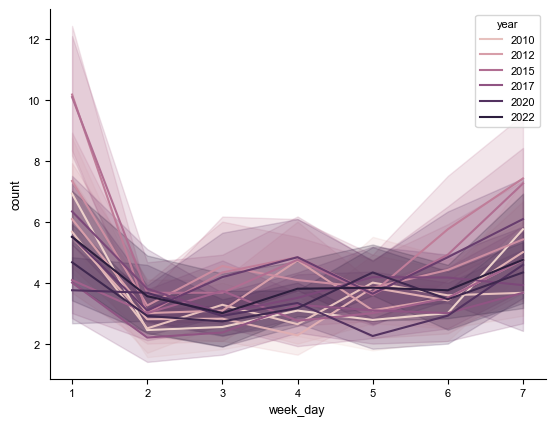

In [7]:
sns.lineplot(data=df[df.problem_type_1 == 'Agression'], x='week_day', y='count', hue='year')

<Axes: xlabel='week_day', ylabel='count'>

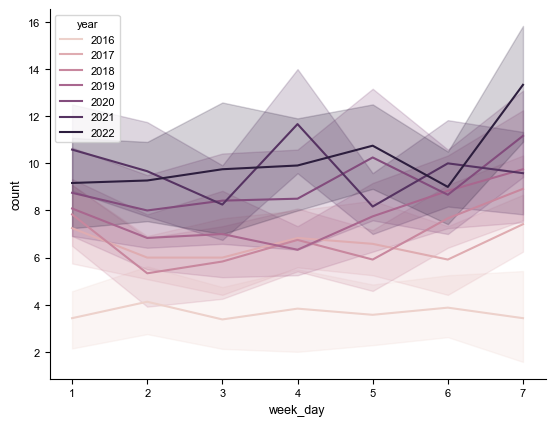

In [19]:
sns.lineplot(data=df[df.problem_type_1 == 'Violation of Protective Measures for women - Lei Maria da Penha'], x='week_day', y='count', hue='year')

<Axes: xlabel='month', ylabel='count'>

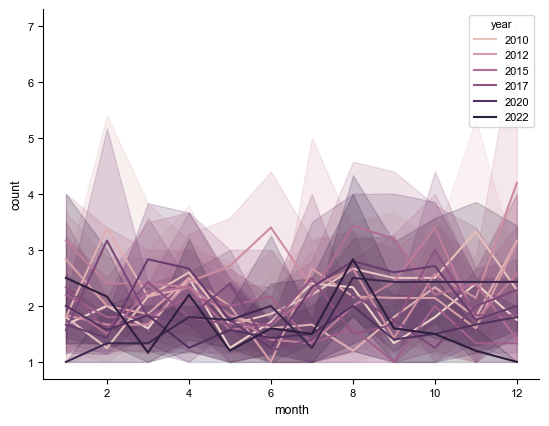

In [12]:
sns.lineplot(data=df[df.problem_type_1 == 'Obscene/libelous acts'], x='month', y='count', hue='year')


In [8]:
y = np.array(list(df['count']))
X = df.drop(['count'], axis=1)

In [9]:
X_train, y_train = X[X.year < 2021], y[X.year < 2021]
X_test, y_test   = X[X.year >= 2021], y[X.year >= 2021]

In [10]:
num_features = ['year', 'month']
cat_features = ['problem_type_1']
ord_features = ['week_day']

In [11]:
numeric_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=4)),
    ('scaler', StandardScaler())])

ordinal_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=4)),  
    ('ordEnc', OrdinalEncoder())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('ord', ordinal_transformer, ord_features),
        ('cat', categorical_transformer, cat_features)])

In [12]:
models2test = {
    'SVR' : SVR(),   
    'DTree': DecisionTreeRegressor(random_state=4392),
    'RForest': RandomForestRegressor(random_state=4392),
    'GradBoost': GradientBoostingRegressor(random_state=4392),
}

In [13]:
param2test = {
    'SVR' : {
        'classifier__C': [0.1, 1, 10, 100], 
        'classifier__kernel': ['rbf', 'poly', 'sigmoid']
    },   
    'DTree': {
        'classifier__max_depth' : [2, 4, 6, 8, 10],
        'classifier__criterion': ['squared_error', 'friedman_mse', 'poisson', 'absolute_error'],
    },
    'RForest': {
        'classifier__n_estimators': [10, 50, 100, 500],
        'classifier__max_depth' : [2, 4, 6, 8, 10],
    },
    'GradBoost': {
        'classifier__max_depth' : [2, 4, 6, 8, 10],
        'classifier__n_estimators': [10, 50, 100, 500],
        'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2]
    },
}

In [65]:
search = dict()
for clf in models2test.keys():
    print(clf)
    
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', models2test[clf])
    ])
    param_grid = param2test[clf]
    search = GridSearchCV(pipeline, param_grid, cv=5).fit(X_train,y_train)
    joblib.dump(search, '{}/paramTuning_{}.pkl'.format(output_folder, clf))

SVR
DTree
RForest
GradBoost


Loading grid search results

In [14]:
bestParams = dict()
bestScores = dict()
bestModels  = dict()
for clf in models2test.keys():
    tmp_load = joblib.load('{}/paramTuning_{}.pkl'.format(output_folder, clf))
    bestParams[clf] = tmp_load.best_params_
    bestScores[clf] = tmp_load.best_score_
    bestModels[clf] = tmp_load.best_estimator_

In [15]:
bestParams

{'SVR': {'classifier__C': 1, 'classifier__kernel': 'rbf'},
 'DTree': {'classifier__criterion': 'absolute_error',
  'classifier__max_depth': 8},
 'RForest': {'classifier__max_depth': 8, 'classifier__n_estimators': 500},
 'GradBoost': {'classifier__learning_rate': 0.1,
  'classifier__max_depth': 4,
  'classifier__n_estimators': 500}}

In [16]:
bestScores

{'SVR': 0.5346250552188035,
 'DTree': 0.5968567824209222,
 'RForest': 0.6316796848393843,
 'GradBoost': 0.6590601511333712}

In [17]:
bestModels

{'SVR': Pipeline(steps=[('preprocessor',
                  ColumnTransformer(transformers=[('num',
                                                   Pipeline(steps=[('imputer',
                                                                    KNNImputer(n_neighbors=4)),
                                                                   ('scaler',
                                                                    StandardScaler())]),
                                                   ['year', 'month']),
                                                  ('ord',
                                                   Pipeline(steps=[('imputer',
                                                                    KNNImputer(n_neighbors=4)),
                                                                   ('ordEnc',
                                                                    OrdinalEncoder())]),
                                                   ['week_day']),
                      

In [18]:
scores = dict()
y_pred = dict()

for clf in models2test.keys():
    print(clf)
    
    scores[clf] = cross_validate(bestModels[clf], X_train, y_train, cv=5,
                                scoring=('neg_root_mean_squared_error'),
                                return_train_score=True, return_estimator=False, return_indices=False) 
    y_pred[clf] = cross_val_predict(bestModels[clf], X_train, y_train, cv=5)
    joblib.dump(scores[clf], '{}/scores_{}.pkl'.format(output_folder, clf))
    joblib.dump(y_pred[clf], '{}/yPred_{}.pkl'.format(output_folder, clf))


SVR
DTree
RForest
GradBoost


In [19]:
for clf in models2test.keys():
    print('-----------------------------------')
    print(clf)
    print('-----------------------------------')
    print('train_rmse mean:  %.4f' % scores[clf]['train_score'].mean())
    print('train_rmse std:  %.4f' % scores[clf]['train_score'].std())
    print('test_rmse mean:  %.4f' % scores[clf]['test_score'].mean())
    print('test_rmse std:  %.4f' % scores[clf]['test_score'].std())
    print('\n')

-----------------------------------
SVR
-----------------------------------
train_rmse mean:  -4.6425
train_rmse std:  0.1935
test_rmse mean:  -5.0637
test_rmse std:  1.1447


-----------------------------------
DTree
-----------------------------------
train_rmse mean:  -3.0284
train_rmse std:  0.0768
test_rmse mean:  -4.5361
test_rmse std:  0.5508


-----------------------------------
RForest
-----------------------------------
train_rmse mean:  -2.8349
train_rmse std:  0.0746
test_rmse mean:  -4.3190
test_rmse std:  0.5096


-----------------------------------
GradBoost
-----------------------------------
train_rmse mean:  -2.8538
train_rmse std:  0.0650
test_rmse mean:  -4.1778
test_rmse std:  0.5362




All models perform more or less equally in the validation set, but SVR has a higher deviation...

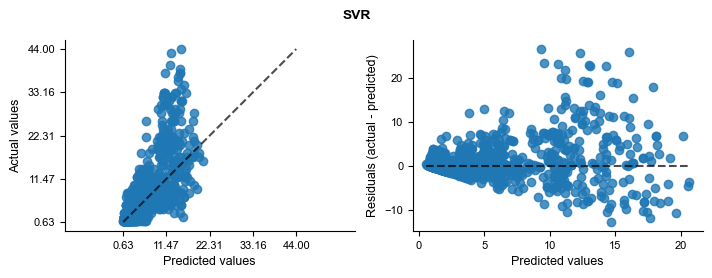

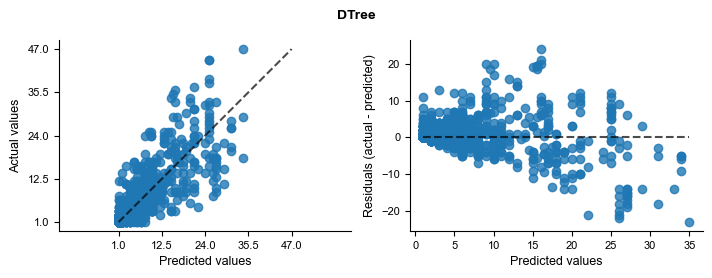

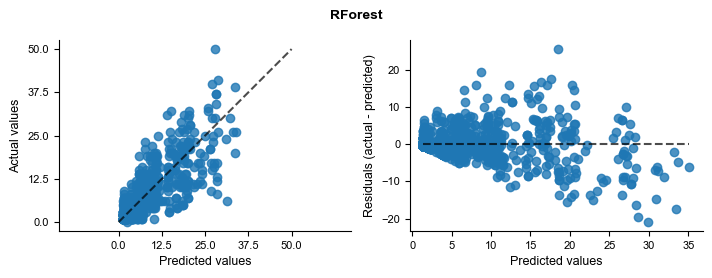

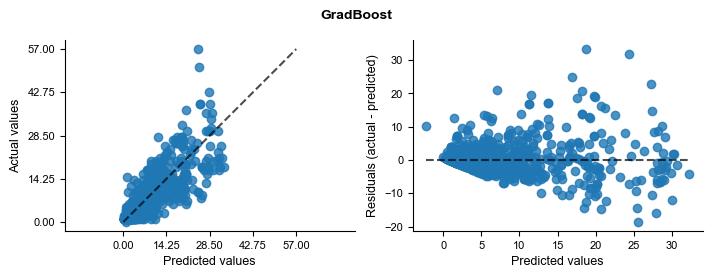

In [20]:
for clf in models2test.keys():
    fig, axs = plt.subplots(ncols=2, figsize=(two_col,7*cm))
    plt.suptitle(clf)
    PredictionErrorDisplay.from_predictions(y_true=y_train, y_pred=y_pred[clf],
                                        kind="actual_vs_predicted", ax=axs[0])
    PredictionErrorDisplay.from_predictions(y_true=y_train, y_pred=y_pred[clf],
                                        kind="residual_vs_predicted", ax=axs[1])
    plt.tight_layout()

The SVR seems to fall short on the predictions... The other models don't seem to be much different from each other, but the GradientBoosting has the less difference between train and test performance, so less prone to overfitting.

Let's check the feature importance for the GradientBoosting using the SHAP lib

In [92]:
preproc = preprocessor.fit(X_train)
X_train_pr = preproc.transform(X_train)
X_test_pr  = preproc.transform(X_test)

In [93]:
feat_names = preproc.get_feature_names_out()
feat_names = [x.split('__')[1] for x in feat_names]
feat_names = [x.split('_')[-1] if 'prob' in x else x for x in feat_names]
feat_names

['year',
 'month',
 'week_day',
 'Abandonment/nonsupport of incompetent person',
 'Abuse of incapacitated persons',
 'Agression',
 'Animal abuse',
 'Arbitrary violence',
 'Break-in',
 'Child grooming/enticement',
 'Concussion (corruption)',
 'Corporal injury',
 'Corruption',
 'Corruption of minors',
 'Crime against corpses',
 'Crime against individual liberty',
 'Crime apology',
 'Defamation',
 'Discrimination',
 'Embezzlement',
 'Environmental crime',
 'Exploitation of minors',
 'Extortion',
 'False Identity',
 'False money',
 'Falsification of Public Document',
 'Favouring prostitution',
 'Fishing in Prohibited Places',
 'Fraud (monetary)',
 'Gambling',
 'Gang',
 'Gang-sacking/pillaging',
 'Gunshot',
 'Homophobia',
 'Illegal possession',
 'Illitcit Substance',
 'Impersonating a public official',
 'Irregular Construction',
 'Irregular landfill',
 'Kidnapping and imprisonment',
 'Loss, concealment or destruction of books or documents',
 'Maltreatment',
 'Misuse of transport card',
 'Mu

In [94]:
feat_names[-1] = 'Wearing uniform of function not exercised'
feat_names[-3] = 'Violation Lei Ma. da Penha'

In [95]:
X_train_pr = pd.DataFrame(X_train_pr.toarray(), columns=feat_names)
X_test_pr  = pd.DataFrame(X_test_pr.toarray(), columns=feat_names)

In [43]:
shap.initjs()

In [96]:
X_train_summary = shap.kmeans(X_train_pr, 10)

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


In [97]:
ex = shap.KernelExplainer(bestModels['GradBoost'][-1].predict, X_train_summary)

  0%|          | 0/2111 [00:00<?, ?it/s]

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


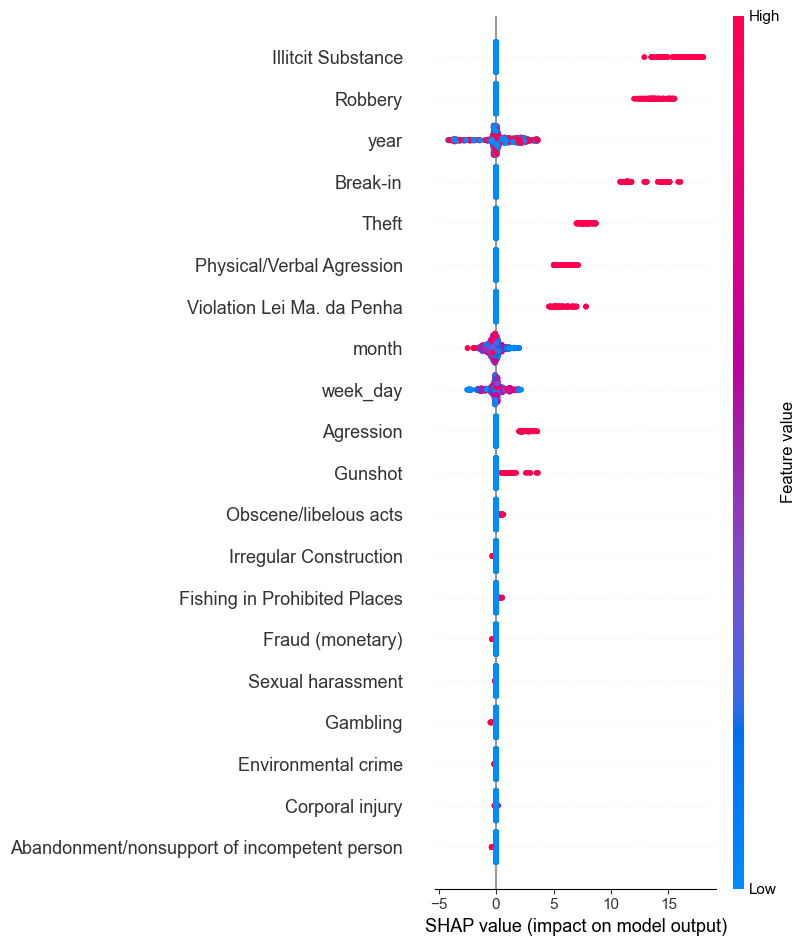

In [98]:
shap_values = ex.shap_values(X_test_pr)
shap.summary_plot(shap_values, X_test_pr)

In [99]:
print(y_test[50])
shap.force_plot(ex.expected_value, shap_values[50,:], X_test_pr.loc[50,:])


8


In [100]:
print(y_test[10])
shap.force_plot(ex.expected_value, shap_values[10,:], X_test_pr.loc[10,:])

16
